In [1]:
import numpy as np
import pandas as pd

# Load and clean up data

In [2]:
df_all = pd.read_csv(r'C:\Users\fyang\CCS-Prediction-Publish\CCS_prediction\PredictionCCS.csv')

In [3]:
df_all['SMILES'].isnull().values.any()
df_all = df_all.dropna(subset=['SMILES', 'CCS'])

In [4]:
import joblib
modelpath = r"C:\Users\fyang\CCS-Prediction-Publish\CCS_prediction\classPred.joblib"
model_class = joblib.load(modelpath)

In [5]:
from rdkit import Chem
from rdkit.Chem import PandasTools

# get fingerprints
def get_FPs(df):
    
    # from SMILES to mol
    PandasTools.AddMoleculeColumnToFrame(df,
                                         'SMILES','Molecules',
                                         includeFingerprints = True)
    df.dropna(subset = ['Molecules'],inplace = True)
    df = df.reset_index()
    # from mol to FPs
    df['FPs'] =[Chem.RDKFingerprint(mol, fpSize = 1024) for mol in df.Molecules]
    
    return df

In [6]:
df_all= get_FPs(df_all)

# Apply to Classification model

In [9]:
FPs = df_all['FPs'].tolist()
df_all['Super.Class'] = model_class.predict(FPs)

In [10]:
# Clean up data
df_all.drop_duplicates(subset=['SMILES','adduct','CCS'], inplace = True)

In [93]:
print(df_all['Super.Class'].value_counts())
print(df_all['adduct'].value_counts())

Lipids and lipid-like molecules    4594
Organoheterocyclic compounds       3634
Benzenoids                         2413
Organic acids and derivatives      1740
Organic oxygen compounds            943
Name: Super.Class, dtype: int64
[M+H]+    7307
[M-H]-    3773
[M+H]     1313
[M-H]      808
[M*]        41
[M]         27
[M.]        25
[M]+        20
[M-H]+       8
M+           2
Name: adduct, dtype: int64


,index,CID,SMILES,adduct,CCS,Super.Class,Source,Molecules,FPs
0,0,14410,C1(=C(C(=C(C(=C1Br)Br)Br)Br)Br)OC2=C(C(=C(C(=C...,[M+H]+,205.23,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,1,16318,C1(=C(C(=C(C(=C1Cl)Cl)Cl)Cl)Cl)C2=C(C(=C(C(=C2...,[M+H]+,185.88,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,2,45472,C1=C(C(=C(C(=C1Br)Br)Br)Br)OC2=C(C(=C(C(=C2Br)...,[M+H]+,202.77,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,3,40484,C1=C(C(=C(C(=C1Cl)Cl)C2=C(C(=C(C(=C2Cl)Cl)Cl)C...,[M+H]+,182.07,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,4,16495,C1=C(C(=C(C(=C1Cl)Cl)C2=C(C(=CC(=C2Cl)Cl)Cl)Cl...,[M+H]+,176.90,Benzenoids,1-s2.0-S0003267018302824-mmc2.csv,,"[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."

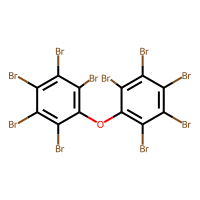
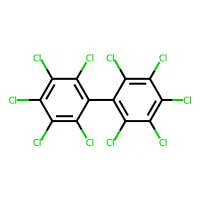
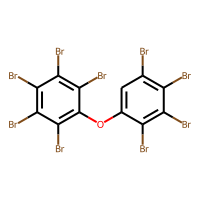
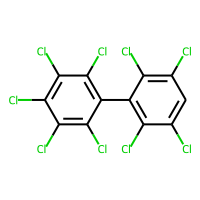
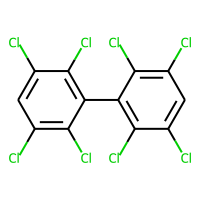

In [12]:
df_all.head(5)

# Modeling

In [13]:
from sklearn.ensemble import RandomForestRegressor

#Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Quality of a split
criterion = ['squared_error']
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [None]
# Minimum number of samples required to split a node
#min_samples_split2 = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 5, stop = 20, num = 5)]
# Use out-of-bag samples to estimate the generalization score. 
oob_score = [True]

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def tuning (df):
    output = {}
    label = df.iloc[0]['Super.Class']
    X = df['FPs'].tolist()
    y = df['CCS'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)
    
    output['Super_Class'] = label
    print(label)
    print('X_train: {}'.format(np.shape(X_train)))
    print('y_train: {}'.format(np.shape(y_train)))
    print('X_test: {}'.format(np.shape(X_test)))
    print('y_test: {}'.format(np.shape(y_test)))
    output['X_test'] = X_test
    output['y_test'] = y_test
    
    param_grid_CCS = {'n_estimators': n_estimators,
              #'criterion': criterion,
              #'max_features': max_features,
              #'max_depth': max_depth,
              #'min_samples_split': min_samples_split2,
              'min_samples_leaf': min_samples_leaf,
             # 'oob_score': oob_score
               }
    
    rfr_Model = RandomForestRegressor(oob_score = [True])
    
    rfr_Grid = GridSearchCV(estimator = rfr_Model, 
                       param_grid = param_grid_CCS, 
                       cv = 5, 
                       verbose=2, 
                       n_jobs = 3,
                       return_train_score = True)
    
    
    rfr_Grid.fit(X_train, y_train)
    output['Grid'] = rfr_Grid
    print(rfr_Grid)
    print(rfr_Grid.best_params_)
    print (f'Train Accuracy - : {rfr_Grid.score(X_train,y_train):.3f}')
    print (f'Test Accuracy - : {rfr_Grid.score(X_test,y_test):.3f}')
    
    
    return output

In [15]:
listOfClass = df_all.groupby('Super.Class')
listOfData = [listOfClass.get_group(x) for x in listOfClass.groups]

In [19]:
summaryOfGridR = [tuning(i) for i in listOfData]

Benzenoids
X_train: (1930, 1024)
y_train: (1930,)
X_test: (483, 1024)
y_test: (483,)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
GridSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=[True]), n_jobs=3,
             param_grid={'min_samples_leaf': [5, 8, 12, 16, 20],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                          411, 455, 500]},
             return_train_score=True, verbose=2)
{'min_samples_leaf': 5, 'n_estimators': 500}
Train Accuracy - : 0.942
Test Accuracy - : 0.869
Lipids and lipid-like molecules
X_train: (3675, 1024)
y_train: (3675,)
X_test: (919, 1024)
y_test: (919,)
Fitting 5 folds for each of 50 candidates, totalling 250 fits
GridSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=[True]), n_jobs=3,
             param_grid={'min_samples_leaf': [5, 8, 12, 16, 20],
                         'n_estimators': [100, 144, 188, 233, 277, 322, 366,
                                       

# Model evaluation

In [21]:
# Plot grid results
import matplotlib.pyplot as plt
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    #fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='-', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

Benzenoids


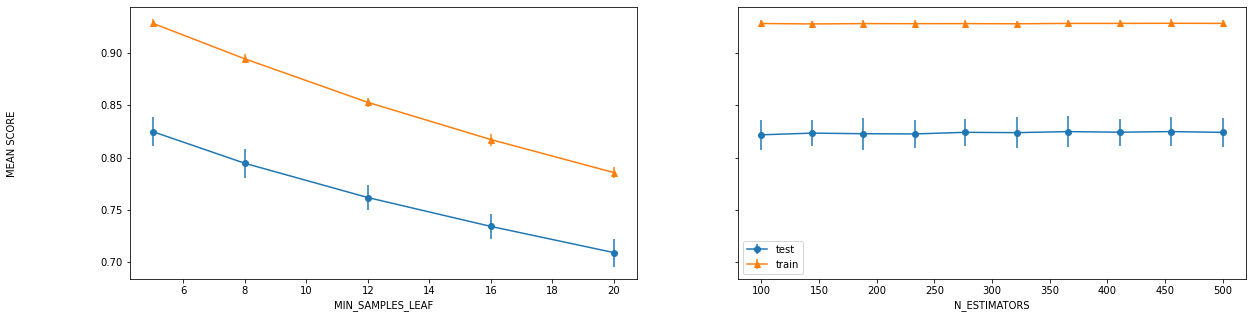

Lipids and lipid-like molecules


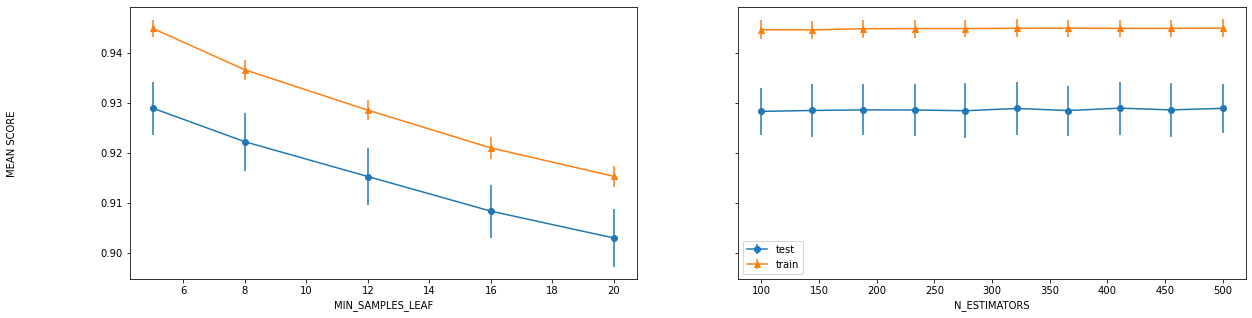

Organic acids and derivatives


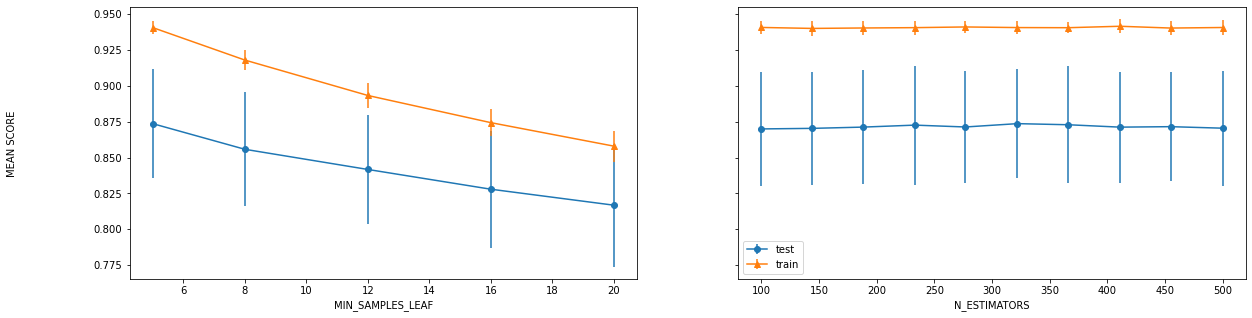

Organic oxygen compounds


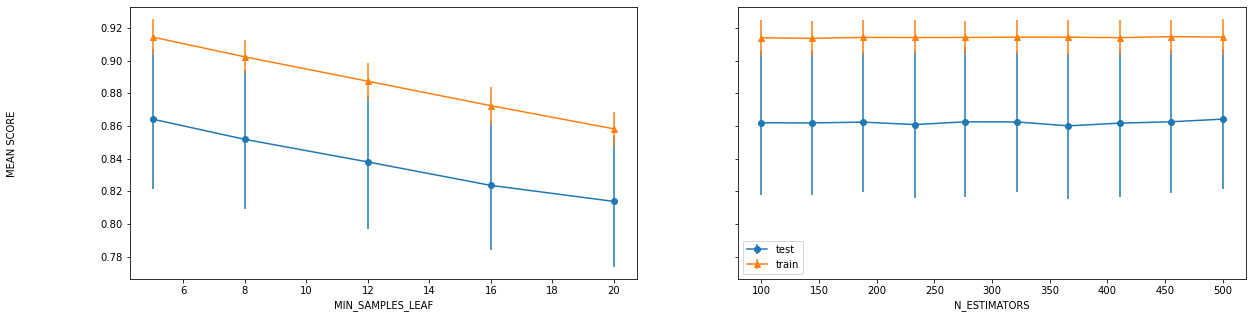

Organoheterocyclic compounds


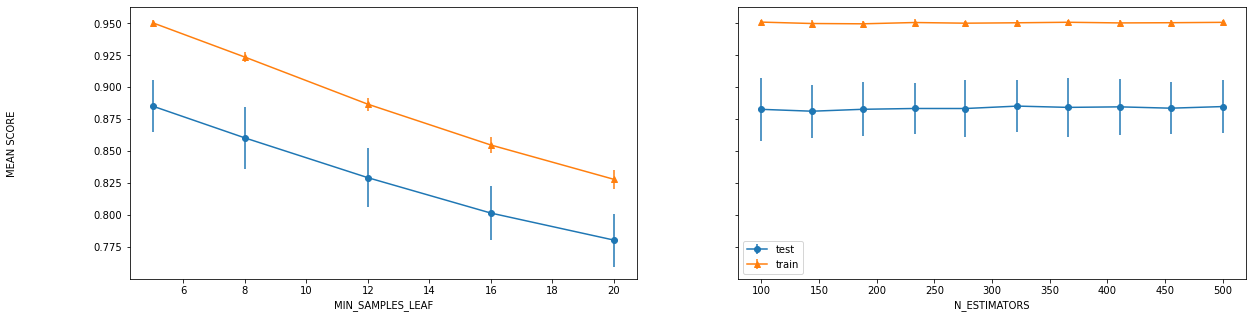

In [42]:
for i in summaryOfGridR2:
    print(i['Super_Class'])
    plot_search_results(i['Grid'])

## Decision Trees

In [27]:
from sklearn.tree import export_graphviz

def plotTrees(Grid, label):
    Grid_opt = Grid.best_estimator_
    for index in range(0, 5):
        export_graphviz(Grid_opt[index], out_file=label+str(index)+'.dot', 
                #feature_names = fn,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [28]:
for i in summaryOfGridR:
    label = i['Super_Class']
    Grid = i['Grid']
    plotTrees(Grid, label)

In [29]:
# Calculate feature importances
def plotFI(Grid, label):
    Grid_opt = Grid.best_estimator_
    importances = Grid_opt.feature_importances_
    # investigate the top 5 importance features
    ind = np.argpartition(importances,-5)[-5:] 
    print(ind)
    print(importances[ind])
    plt.plot(importances)
    #plt.ylim([0, importances])
    plt.title('Feaure_importances 0f '+ label)
    plt.xlabel('Features_FPs_1024bits')
    plt.ylabel('Feature_importances')
    plt.savefig(label+'_FeatureImportances.png',bbox_inches='tight',dpi = 100)

[209 919 793 875 268]
[0.02050481 0.03735457 0.05063782 0.06627741 0.11790281]
Benzenoids
[ 144 1009  364  520  215]
[0.03426974 0.12108123 0.0442315  0.20020397 0.36518486]
Lipids and lipid-like molecules
[ 73 654 408 538 588]
[0.01678887 0.02587993 0.02808038 0.03516343 0.49137177]
Organic acids and derivatives
[141 492 305 406 230]
[0.02895002 0.44698255 0.05216392 0.04745332 0.04492804]
Organic oxygen compounds
[666 792 569 249 748]
[0.02406237 0.03428904 0.04196655 0.05846717 0.22576028]
Organoheterocyclic compounds


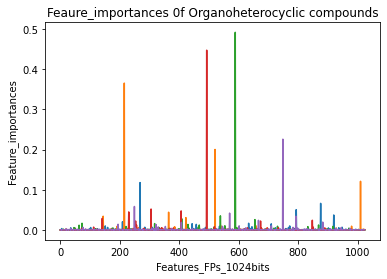

In [30]:
for i in summaryOfGridR:
    label = i['Super_Class']
    Grid = i['Grid']
    plotFI(Grid, label)
    print(label)

In [100]:
from rdkit.Chem import Draw
from rdkit import Chem
# get feature examples
def get_svgs(mols,ind):
    rdkbi = {}
    rdkfp = Chem.RDKFingerprint(mols, 2, fpSize = 1024, bitInfo=rdkbi)
    svg = Draw.DrawRDKitBit(mols, ind, rdkbi, useSVG=True)
    return(svg)

In [215]:
#for i in ind:
import random
def random_indices(feature):
    indices = []
    while len(indices) <10:
        j = random.randint(0,13324)
        if df_all['FPs'][j][feature] == 1:
            indices.append(j)
    return indices

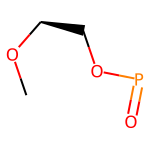

In [121]:
from IPython.core.display import display
indices215 = random_indices(215)
random_mols = random.choice(indices215)
mols = df_all['Molecules'] [random_mols]
svg = get_svgs(mols, 215)
display(svg)

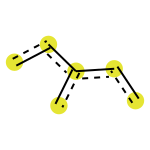

In [222]:
indices588 = random_indices(588)
random_mols = random.choice(indices588)
mols = df_all['Molecules'] [random_mols]
svg = get_svgs(mols, 588)
display(svg)

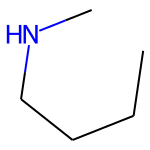

In [123]:
indices268 = random_indices(268)
random_mols = random.choice(indices268)
mols = df_all['Molecules'] [random_mols]
svg = get_svgs(mols, 268)
display(svg)

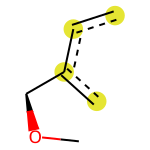

In [132]:
indices748 = random_indices(748)
random_mols = random.choice(indices748)
mols = df_all['Molecules'] [random_mols]
svg = get_svgs(mols, 748)
display(svg)

# Evaluation

,index,CID,SMILES,adduct,CCS,Super.Class,Source,Molecules,FPs,pred,res,%res
134,134,447315,[C@@H]([C@@H](C(=O)O)O)(C(=O)O)O,[M-H],118.4,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",119.661367,-1.261367,0.010653
137,137,439655,[C@H]([C@@H](C(=O)O)O)(C(=O)O)O,[M-H],118.3,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",119.661367,-1.361367,0.011508
150,150,5460407,C([C@@H]([C@H](C(=O)O)O)O)O,[M+H],136.1,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",122.938160,13.161840,0.096707
152,152,6267,C([C@@H](C(=O)O)N)C(=O)N,[M-H],124.2,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",128.718271,-4.518271,0.036379
163,163,193653,C([C@@H](C(=O)O)N)SCC(=O)O,[M+H],137.1,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",135.419686,1.680314,0.012256
164,164,67678,C([C@@H](C(=O)O)N)SSC[C@@H](C(=O)O)N,[M-H],143.3,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",146.936164,-3.636164,0.025374
225,225,NaN,C([C@H](C(=O)O)O)C(=O)O,[M-H],116.3,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",118.329598,-2.029598,0.017451
233,233,763,C(C(=O)O)N=C(N)N,[M+H],125.4,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",126.831435,-1.431435,0.011415
258,258,NaN,C(C[C@@H](C(=O)O)N)[C@H](CN)O,[M-H],134.2,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ...",134.468725,-0.268725,0.002002
261,261,439283,C(C[C@@H](C(=O)O)N)C[C@@H](C(=O)O)N,[M+H],141.4,Organic acids and derivatives,20190304JAP_CCSdatabase_final.csv,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",140.493396,0.906604,0.006412

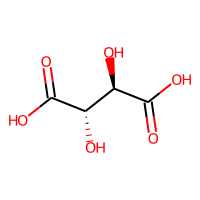
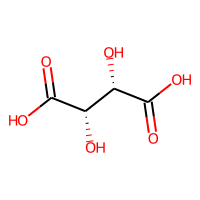
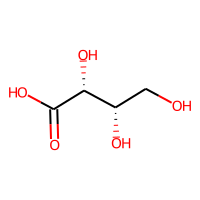
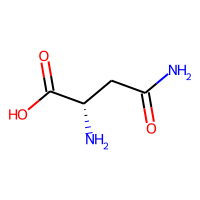
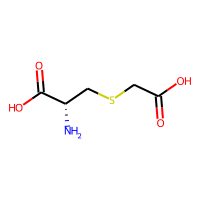
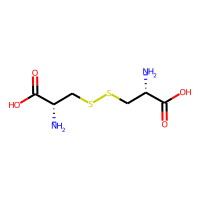
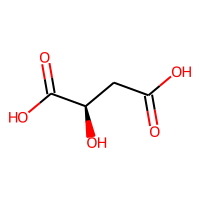
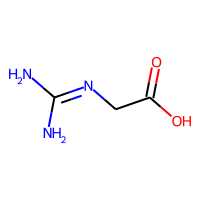
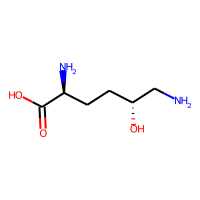
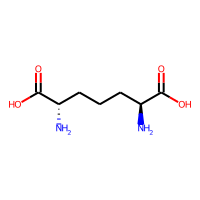
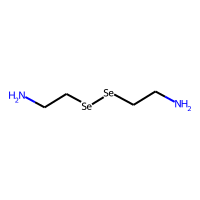
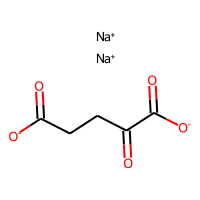
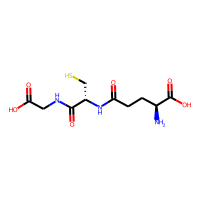
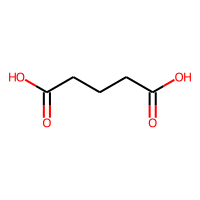
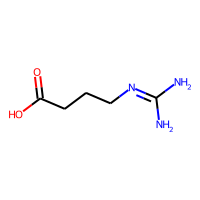
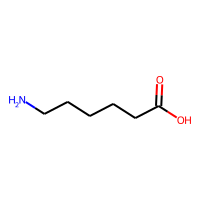
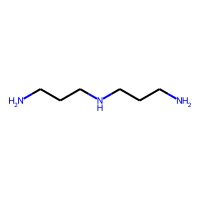
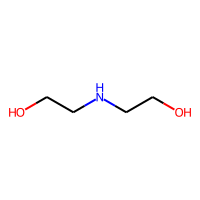
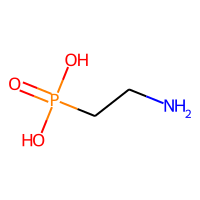
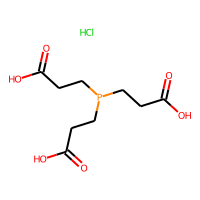
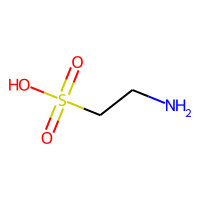
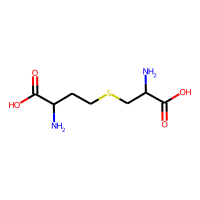
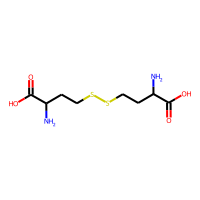
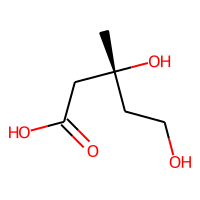
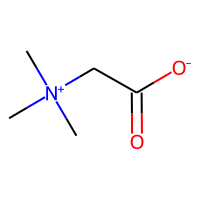
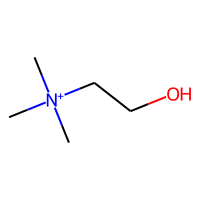
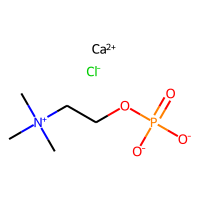
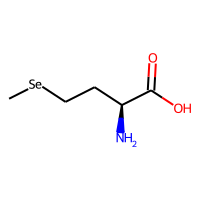
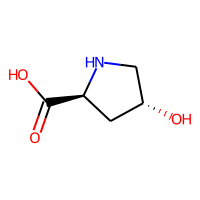
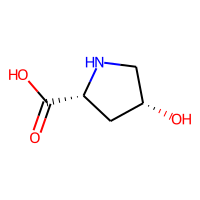
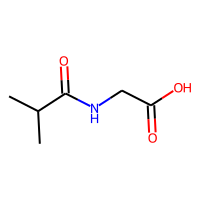
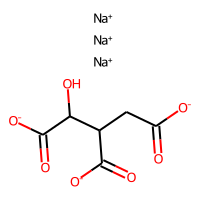
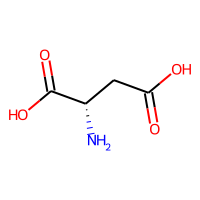
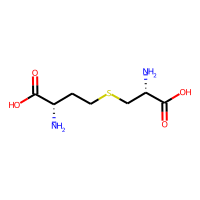
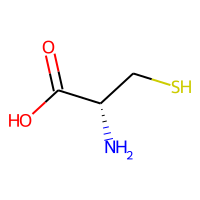
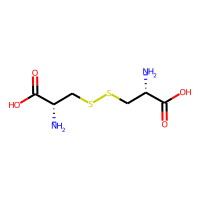
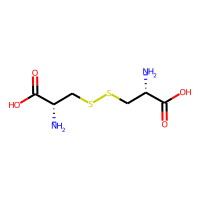
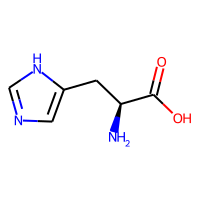
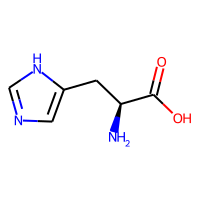
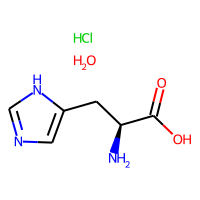
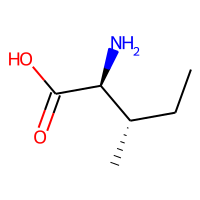
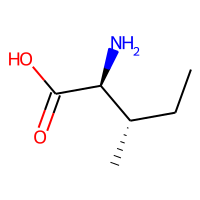
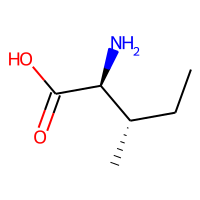
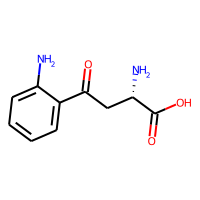
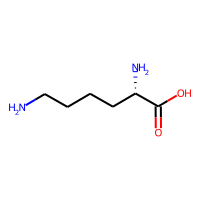
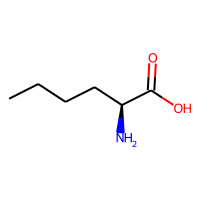
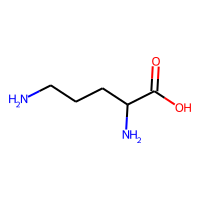
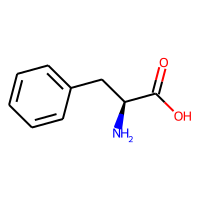
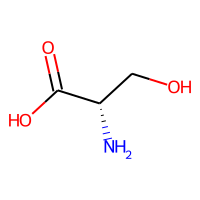
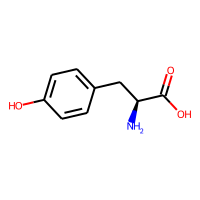
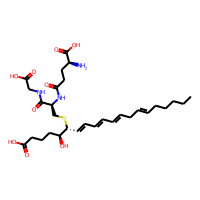
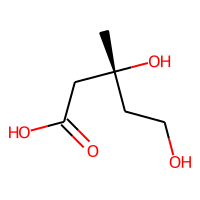
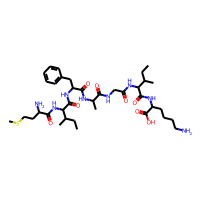
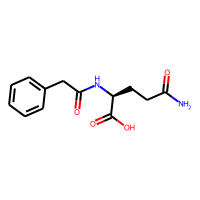
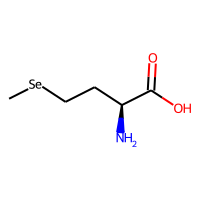
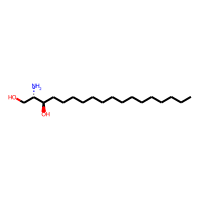
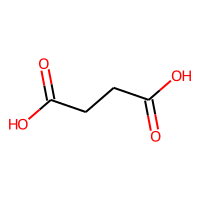
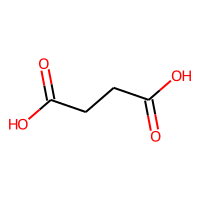
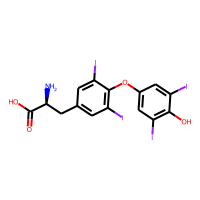
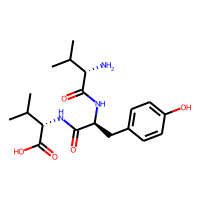

In [185]:
listOfDataTest[2]

In [62]:
listOfDataTest = []
for i in range (5):
    X_test = summaryOfGridR[i]['X_test']
    y_test = summaryOfGridR[i]['y_test']
    grid = summaryOfGridR[i]['Grid']
    print(np.shape(X_test))
    subdf = listOfData[i]
    #extract test datafram by pair testFeatures
    df_test = subdf[subdf.FPs.isin(X_test)]
    df_test['pred'] = grid.predict(df_test['FPs'].tolist())
    print(df_test.shape[0])
    listOfDataTest.append(df_test)

(483, 1024)


C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


492
(919, 1024)


C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


963
(348, 1024)


C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


365
(189, 1024)
209
(727, 1024)
739


C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [68]:
for i in listOfDataTest:
    i['res'] = i['CCS'] - i['pred']
    i['%res'] = abs(i['res']/i['CCS'])

C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
df_Testset = pd.concat(listOfDataTest)
df_Testset.to_csv('Testset_class.csv',index=False)

,index,CID,SMILES,adduct,CCS,Super.Class,Source,Molecules,FPs,pred,res,%res
6494,6494,14819046,C(C1C(C(C(C(O1)OC2C(OC(C(C2O)O)OC3C(OC(C(C3O)O...,[M+H]+,390.300000,Organic oxygen compounds,CCSbase,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",226.594764,163.705236,0.419434
2789,2789,440995,C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]...,[M-H]-,170.233333,Organic oxygen compounds,metabolitedata.csv,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",226.594764,-56.361431,0.331083
1651,1651,441314,C1[C@@H]([C@H]([C@@H]([C@H](N1CCO)CO)O)O)O,[M+H]+,141.048864,Organic oxygen compounds,drugCCS_ac7b01709_si_003.csv,,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, ...",187.074377,-46.025513,0.326309
11094,11094,52928607,CC/C=C\C/C=C\C/C=C\C/C=C\C/C=C\C/C=C\CCC(=O)OC...,[M-H]-,237.010000,Organic oxygen compounds,CCSbase,,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, ...",165.926030,71.083970,0.299920
12957,12957,104938,C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]...,[M-H]-,176.800000,Organic oxygen compounds,NORMAN-SLE | S50,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",226.594764,-49.794764,0.281645
171,171,104938,C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]...,[M-H],176.800000,Organic oxygen compounds,20190304JAP_CCSdatabase_final.csv,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",226.594764,-49.794764,0.281645
6263,6263,6134,C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@@H]...,[M-H]-,176.900000,Organic oxygen compounds,CCSbase,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",226.594764,-49.694764,0.280920
1537,1537,442534,C[C@]12C[C@@]3([C@@H]4C[C@]1([C@@]4([C@H](O2)O...,[M-H]+,206.034476,Organic oxygen compounds,drugCCS_ac7b01709_si_003.csv,,"[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, ...",260.117917,-54.083441,0.262497
6499,6499,9919918,C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@@H]2[...,[M+H]+,303.300000,Organic oxygen compounds,CCSbase,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",226.594764,76.705236,0.252902
6496,6496,444041,C([C@@H]1[C@@H]2[C@@H]([C@H]([C@H](O1)O[C@@H]3...,[M+H]+,301.300000,Organic oxygen compounds,CCSbase,,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, ...",226.594764,74.705236,0.247943

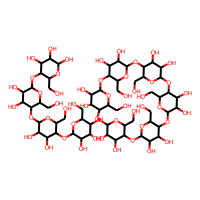
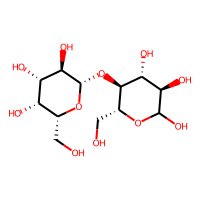
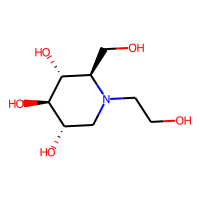
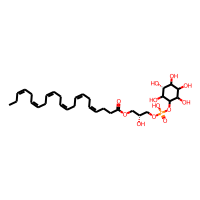
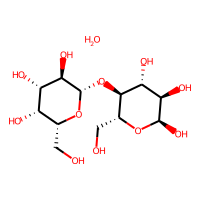
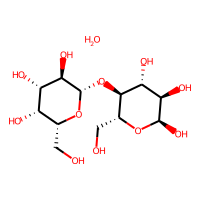
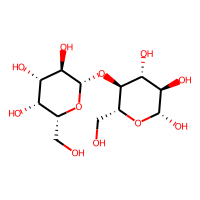
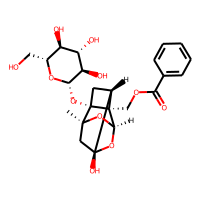
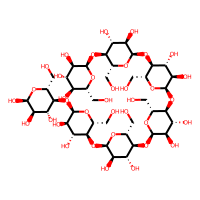
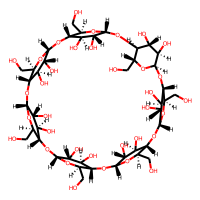
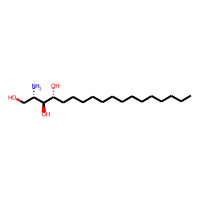
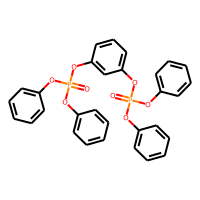
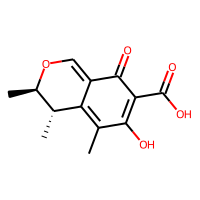
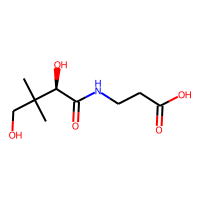
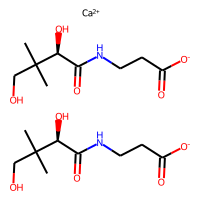
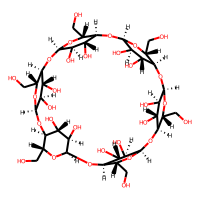
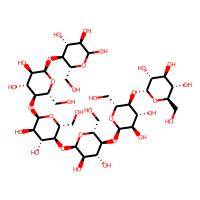
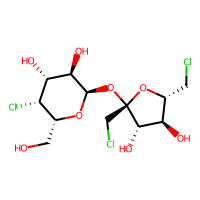
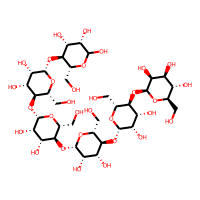
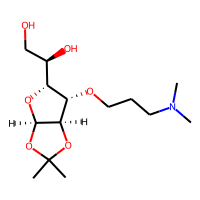
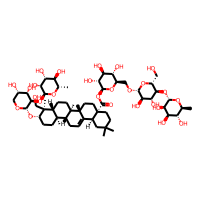
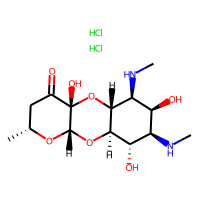
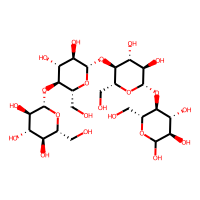
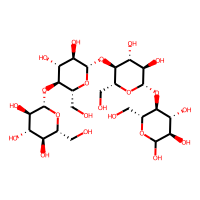
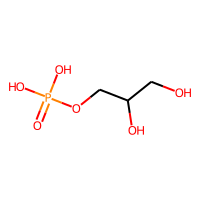
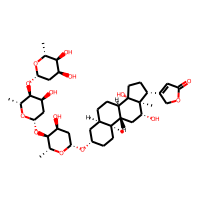
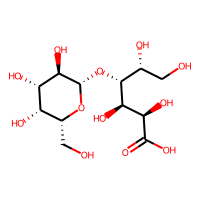
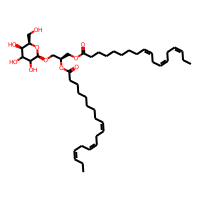
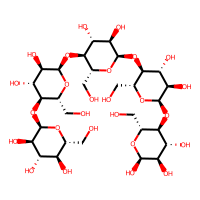
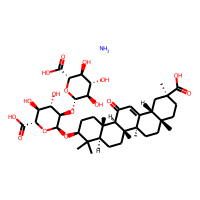
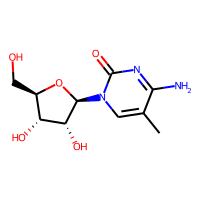
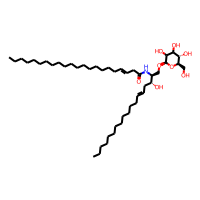
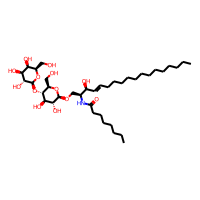
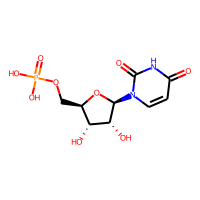
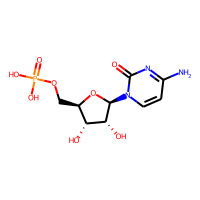
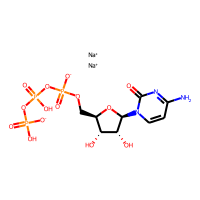
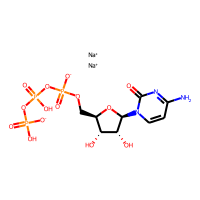
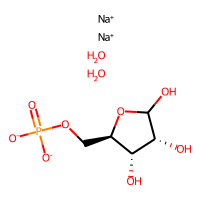
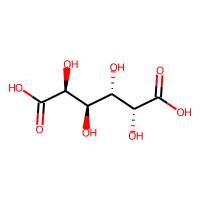
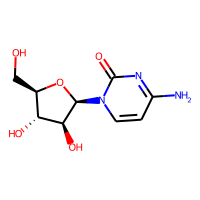
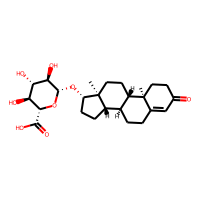
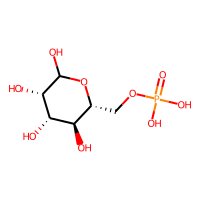
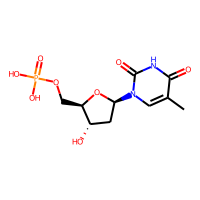
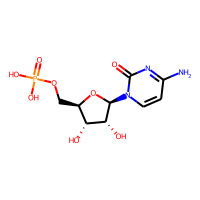
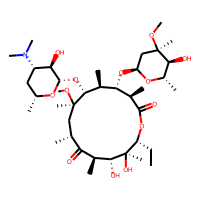
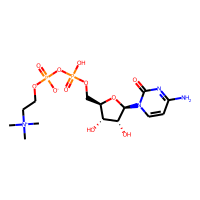
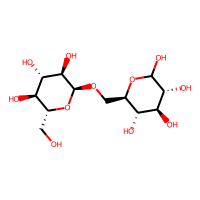
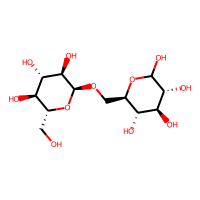
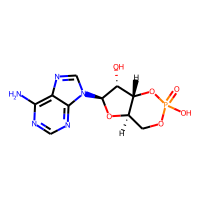
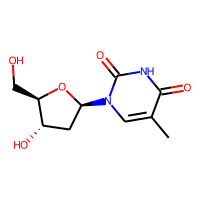
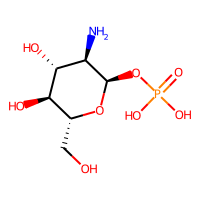
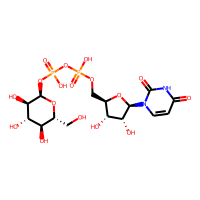
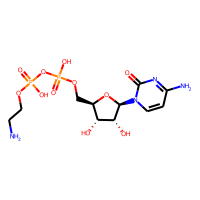
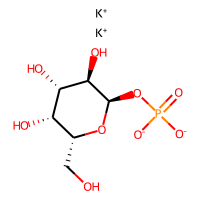
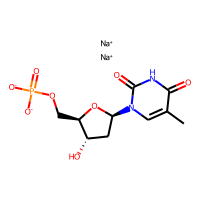
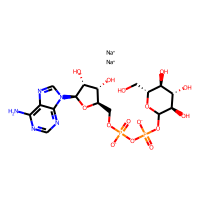
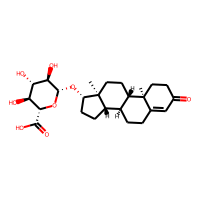
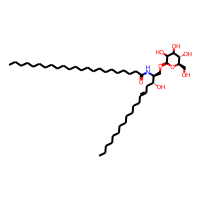
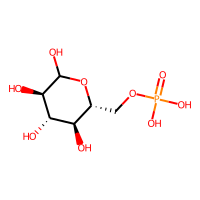
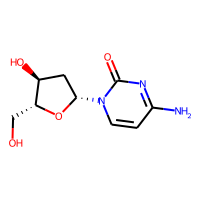

In [236]:
listOfDataTest[3].sort_values(by=['%res'],ascending = False)

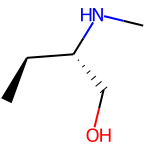

In [226]:
random_mols = random.choice(indices588)
mols = df_all['Molecules'] [5783]
svg = get_svgs(mols, 922)
display(svg)

In [50]:
for i in summaryOfGridR:
    y_test = i['y_test']
    X_test = i['X_test']
    grid = i['Grid']
    pred = grid.predict(X_test)
    i['pred'] = pred
    relative_residual = abs((pred-y_test)/(y_test))
    i['%residual'] = relative_residual
    print(i['Super_Class'])
    print(np.median(relative_residual))

Benzenoids
0.018882995194792956
Lipids and lipid-like molecules
0.023342609059567
Organic acids and derivatives
0.022133648051443335
Organic oxygen compounds
0.023306181622219344
Organoheterocyclic compounds
0.019573478565282104


C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
C:\Users\fyang\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


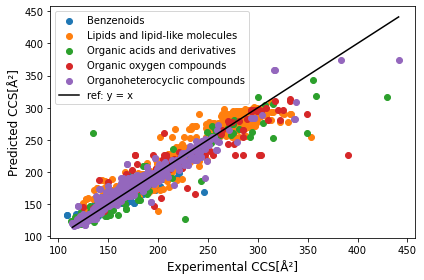

In [234]:
fig = plt.figure()



colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd']


for i, color in zip(range(5), colors):   
    y_test = summaryOfGridR[i]['y_test']
    grid = summaryOfGridR[i]['Grid']
    pred = summaryOfGridR[i]['pred']
    label = summaryOfGridR[i]['Super_Class']
    
    
    
    lims = [
   np.min(min(y_test)),  # min of both axes
   np.max(max(y_test)),  # max of both axes
   ]
    
    plt.scatter(y_test, pred, c = color, label =label)
    
plt.plot(lims, lims, 'k-', c = 'black', label = 'ref: y = x')
    
plt.xlabel('Experimental CCS[Å²]', fontsize = 12)
plt.ylabel('Predicted CCS[Å²]', fontsize = 12)
    
    # no classifier CCS prediction
    
#for ax in axs:
#    ax.legend(loc = 2, fontsize = 'large')
plt.legend()
fig.tight_layout()
fig.show()
fig.savefig('classes_compareone.png')

In [237]:
filename = 'summary_ClassGridR_final.joblib'
joblib.dump(summaryOfGridR, filename)

['summary_ClassGridR_final.joblib']

In [44]:
df_all.to_csv('AllClassPredictedData.csv', index = False)